#HYBRID MODEL: TRAINING PHASE

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Load the dataset
data = pd.read_csv('sorted_energy_data.csv', parse_dates=['Datetime'], index_col='Datetime')
data = data.sort_index()  # Ensure the data is sorted by datetime
print(data.head(10))  # Display first 10 rows to check data
df = data




                      NI_MW
Datetime                   
2004-05-01 01:00:00  9198.0
2004-05-01 02:00:00  8570.0
2004-05-01 03:00:00  8183.0
2004-05-01 04:00:00  7917.0
2004-05-01 05:00:00  7828.0
2004-05-01 06:00:00  7806.0
2004-05-01 07:00:00  8082.0
2004-05-01 08:00:00  8267.0
2004-05-01 09:00:00  8830.0
2004-05-01 10:00:00  9381.0


In [ ]:
import numpy as np
import pandas as pd
import sklearn.preprocessing

# Normalize Data (Min-Max Scaling)
def normalize_data(train_df, test_df):
    scaler = sklearn.preprocessing.MinMaxScaler()
    train_df = train_df.copy()
    test_df = test_df.copy()
    train_df['NI_MW'] = scaler.fit_transform(train_df['NI_MW'].values.reshape(-1, 1))
    test_df['NI_MW'] = scaler.transform(test_df['NI_MW'].values.reshape(-1, 1))
    return train_df, test_df, scaler

# Function to create sequences
def load_data(stock, seq_len):
    X_data, y_data = [], []
    for i in range(seq_len, len(stock)):
        X_data.append(stock.iloc[i-seq_len:i].values)  # All columns for multivariate
        y_data.append(stock.iloc[i, 0])  # Target column (NI_MW)
    return np.array(X_data), np.array(y_data)

# Split into train and test
train_size = int(len(df) * 0.8)
train_data, test_data = df.iloc[:train_size], df.iloc[train_size:]

# Normalize
train_data, test_data, scaler = normalize_data(train_data, test_data)

# Sequence length
seq_len = 24

# Create sequences
X_train, y_train = load_data(train_data, seq_len)
X_test, y_test = load_data(test_data, seq_len)

# Split into training and validation
val_size = int(len(X_train) * 0.2)
X_val, y_val = X_train[-val_size:], y_train[-val_size:]
X_train, y_train = X_train[:-val_size], y_train[:-val_size]

# Reshape for time-series models
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], -1))
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], -1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], -1))

# Print shapes
print(f'X_train.shape = {X_train.shape}, y_train.shape = {y_train.shape}')
print(f'X_val.shape = {X_val.shape}, y_val.shape = {y_val.shape}')
print(f'X_test.shape = {X_test.shape}, y_test.shape = {y_test.shape}')


X_train.shape = (24165, 24, 1), y_train.shape = (24165,)
X_val.shape = (6041, 24, 1), y_val.shape = (6041,)
X_test.shape = (7534, 24, 1), y_test.shape = (7534,)


In [ ]:
df.shape

(58450, 1)

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Define the model architecture
def create_cnn_rnn_model(input_shape):
    model = Sequential()

    # CNN Layer: Extract features
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2))

    # Additional CNN Layers (Optional)
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))

    # LSTM Layer: Learn sequential dependencies (no need to Flatten here)
    model.add(LSTM(units=50, activation='relu', return_sequences=False))

    # Dropout for regularization
    model.add(Dropout(0.2))

    # Fully Connected Layer
    model.add(Dense(units=1))  # Output prediction for the next value

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

    return model

# Define input shape based on the data (samples, time_steps, features)
input_shape = (X_train.shape[1], X_train.shape[2])  # (seq_len, 1)

# Create the model
model = create_cnn_rnn_model(input_shape)

# Summarize the model to view the architecture
model.summary()



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)                    │ (None, 22, 64)              │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 11, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_4 (Conv1D)                    │ (None, 9, 128)              │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_3 (MaxPooling1D)       │ (None, 4, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 50)                  │          35,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 60,811 (237.54 KB)

 Trainable params: 60,811 (237.54 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the model
model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_val, y_val))

Epoch 1/20
585/585 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.0193 - val_loss: 0.0048
Epoch 2/20
585/585 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0043 - val_loss: 0.0018
Epoch 3/20
585/585 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0029 - val_loss: 0.0018
Epoch 4/20
585/585 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0024 - val_loss: 0.0015
Epoch 5/20
585/585 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0021 - val_loss: 0.0011
Epoch 6/20
585/585 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0019 - val_loss: 0.0011
Epoch 7/20
585/585 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0017 - val_loss: 9.5358e-04
Epoch 8/20
585/585 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0016 - val_loss: 0.0011
Epoch 9/20
585/585 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0015 - val_loss: 8.6283e-04
Epoch 10/20
585/585 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0014 - val_loss: 7.5142e-04
Epoch 11/20
585/585 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0014 - val_loss: 7.3642e-04
Epoch 12/20
585/585 ━━━━━━━━━━━━━━━

In [ ]:
# Continuing training for 30 more epochs
model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_val, y_val), initial_epoch=20)


Epoch 21/50
585/585 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0011 - val_loss: 5.9841e-04
Epoch 22/50
585/585 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0011 - val_loss: 5.3721e-04
Epoch 23/50
585/585 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0011 - val_loss: 5.4746e-04
Epoch 24/50
585/585 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0011 - val_loss: 5.3614e-04
Epoch 25/50
585/585 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0010 - val_loss: 5.7661e-04
Epoch 26/50
585/585 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0010 - val_loss: 5.8575e-04
Epoch 27/50
585/585 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0010 - val_loss: 5.8603e-04
Epoch 28/50
585/585 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0010 - val_loss: 9.0158e-04
Epoch 29/50
585/585 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0011 - val_loss: 5.3496e-04
Epoch 30/50
585/585 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0010 - val_loss: 4.6044e-04
Epoch 31/50
585/585 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0010 - val_loss: 5.1298e-04

With 20 epochs

365/365 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


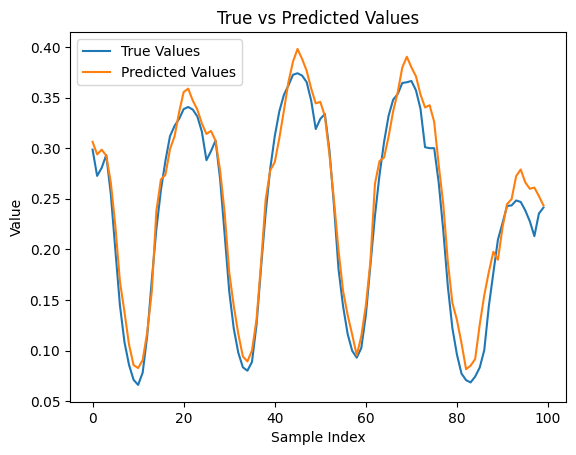

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming y_pred is the predictions made by the model
y_pred = model.predict(X_test)

# Plot predictions vs true values for the test set
plt.plot(y_test[:100], label='True Values')
plt.plot(y_pred[:100], label='Predicted Values')
plt.legend()
plt.title('True vs Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.show()


In [ ]:
# Continuing training for more epochs
model.fit(X_train, y_train, epochs=80, batch_size=64, validation_data=(X_val, y_val), initial_epoch=50)


Epoch 51/80
585/585 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 8.8172e-04 - val_loss: 4.4330e-04
Epoch 52/80
585/585 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 8.9421e-04 - val_loss: 4.1147e-04
Epoch 53/80
585/585 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 8.6103e-04 - val_loss: 4.7488e-04
Epoch 54/80
585/585 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 8.8627e-04 - val_loss: 3.8229e-04
Epoch 55/80
585/585 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 8.8335e-04 - val_loss: 4.5236e-04
Epoch 56/80
585/585 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 8.4764e-04 - val_loss: 4.3126e-04
Epoch 57/80
585/585 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 9.0892e-04 - val_loss: 4.8137e-04
Epoch 58/80
585/585 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 8.4349e-04 - val_loss: 4.2402e-04
Epoch 59/80
585/585 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 8.7948e-04 - val_loss: 4.4211e-04
Epoch 60/80
585/585 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 8.3969e-04 - val_loss: 3.6904e-04
Epoch 61/80
585/585 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/st

365/365 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


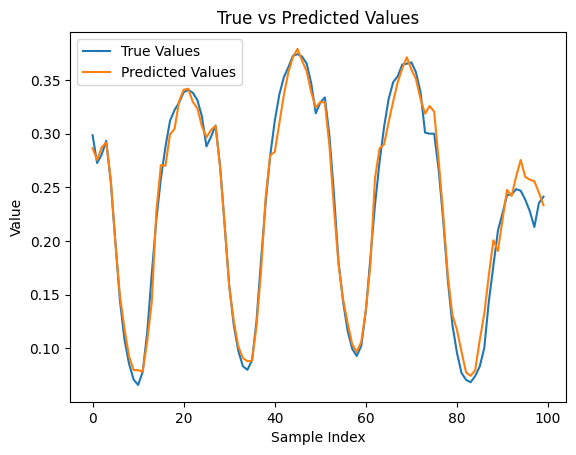

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming y_pred is the predictions made by the model
y_pred = model.predict(X_test)

# Plot predictions vs true values for the test set
plt.plot(y_test[:100], label='True Values')
plt.plot(y_pred[:100], label='Predicted Values')
plt.legend()
plt.title('True vs Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.show()


In [ ]:
model.save("hybrid-model.h5")

In [ ]:
model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_val, y_val), initial_epoch=80)


Epoch 81/100
585/585 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 8.2970e-04 - val_loss: 4.2143e-04
Epoch 82/100
585/585 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 8.1867e-04 - val_loss: 3.5924e-04
Epoch 83/100
585/585 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 8.1518e-04 - val_loss: 4.6626e-04
Epoch 84/100
585/585 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 8.2662e-04 - val_loss: 3.7983e-04
Epoch 85/100
585/585 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 8.0642e-04 - val_loss: 3.9423e-04
Epoch 86/100
585/585 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 8.1817e-04 - val_loss: 3.7854e-04
Epoch 87/100
585/585 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 7.9005e-04 - val_loss: 4.1847e-04
Epoch 88/100
585/585 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 8.4600e-04 - val_loss: 4.5790e-04
Epoch 89/100
585/585 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 8.1648e-04 - val_loss: 3.8220e-04
Epoch 90/100
585/585 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 8.1044e-04 - val_loss: 3.9612e-04
Epoch 91/100
585/585 ━━━━━━━━━━━━━━━━━━━

In [ ]:
model.save("hybrid-model-100.h5")

365/365 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


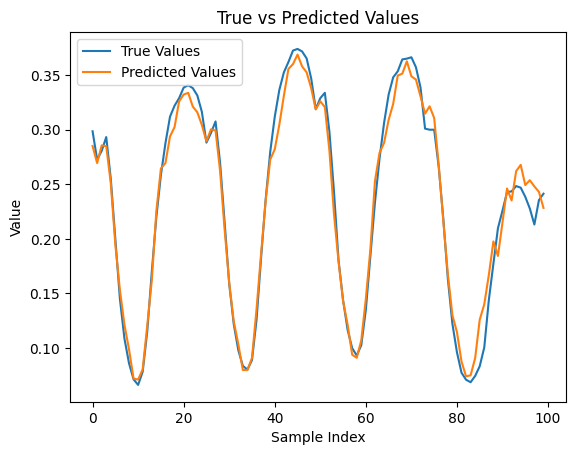

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming y_pred is the predictions made by the model
y_pred = model.predict(X_test)

# Plot predictions vs true values for the test set
plt.plot(y_test[:100], label='True Values')
plt.plot(y_pred[:100], label='Predicted Values')
plt.legend()
plt.title('True vs Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.show()
